In [371]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

from pprint import pprint

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split

import pickle
import random

## 1. DATA LOAD

In [4]:
# sqlalchemy를 이용하여 서버에 있는 data를 dataframe으로 가져옴
engine = create_engine('mysql://{}:{}@{}/{}?charset=utf8'.format(user, pwd, server, db_name), convert_unicode = True)
connect = engine.connect()

raw_data = pd.read_sql_table('data_set', connect)
raw_data.tail(5)

c:\Python36\lib\site-packages\sqlalchemy\dialects\mysql\base.py:1569: Warning: (1287, "'@@tx_isolation' is deprecated and will be removed in a future release. Please use '@@transaction_isolation' instead")
  cursor.execute('SELECT @@tx_isolation')


,user,title,genre,score
90147,ysd5,닥터 스트레인지,액션,10
90148,ysd5,신비한 동물사전,판타지,10
90149,ysd5,탐정 홍길동: 사라진 마을,드라마,9
90150,ysd5,주토피아,애니메이션,10
90151,ysd5,인턴,코미디,10


In [5]:
%%time
# 10개 이하의 평가를 받은 영화를 제거한 새로운 데이터프레임 생성
def refining_df(raw_df):

    title_number_df = raw_df.groupby('title').count().sort_values('user')
    title_under_10 = title_number_df[title_number_df.user <= 10]
    title_under_10_list = list(title_under_10.index)

    for title in title_under_10_list:
        raw_df = raw_df[raw_df['title'] != title]

    return raw_df

raw_df = refining_df(raw_data)
new_df = raw_df.reset_index(drop=True)

Wall time: 2min 29s


In [6]:
new_df.tail(2)

,user,title,genre,score
73458,ysd5,주토피아,애니메이션,10
73459,ysd5,인턴,코미디,10


#### COPY DATA

In [7]:
df = new_df.copy()
df.tail(2)

,user,title,genre,score
73458,ysd5,주토피아,애니메이션,10
73459,ysd5,인턴,코미디,10


## 2. DATA 탐색

#### (1) 전체 유저와 영화의 수 확인

In [48]:
user_num = df.user.unique().shape[0]
movie_num = df.title.unique().shape[0]

print("유저의 수는 {}명 이고,\n영화의 수는 {}개 입니다.".format(user_num, movie_num))

유저의 수는 1837명 이고,
영화의 수는 1593개 입니다.


#### (2) 평점을 많이 남긴 유저 TOP 10

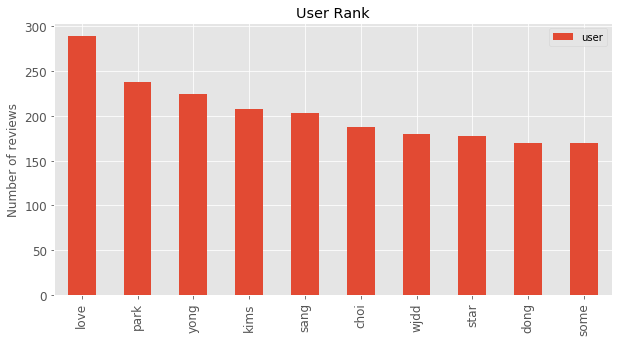

In [10]:
user_top_10 = df.user.value_counts()[:10]

plt.style.use('ggplot')
user_top_10.plot(kind = 'bar', title = 'User Rank',
                            figsize = (10, 5), legend = True, fontsize = 12)
plt.ylabel("Number of reviews", fontsize = 12)
plt.show()

#### (3) 유저들로 부터 평점을 많이 받은 영화 TOP 10

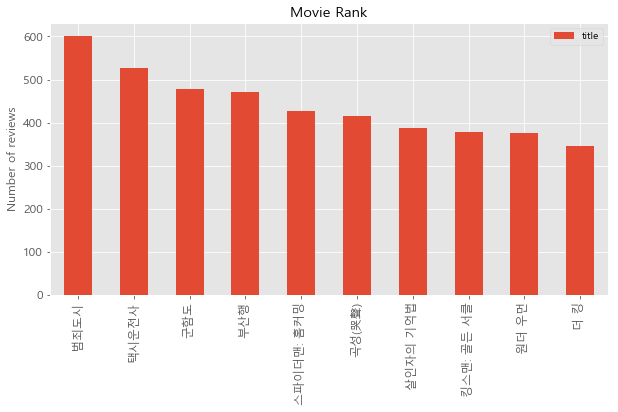

In [11]:
# matplotlib에서 한글 사용
font_name = font_manager.FontProperties(fname = "c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family = font_name)

movie_top_10 = df.title.value_counts()[:10]

plt.style.use('ggplot')
movie_top_10.plot(kind = 'bar', title = 'Movie Rank',
                            figsize = (10, 5), legend = True, fontsize = 12)
plt.ylabel("Number of reviews", fontsize = 12)
plt.show()

#### (4) Score 랭킹

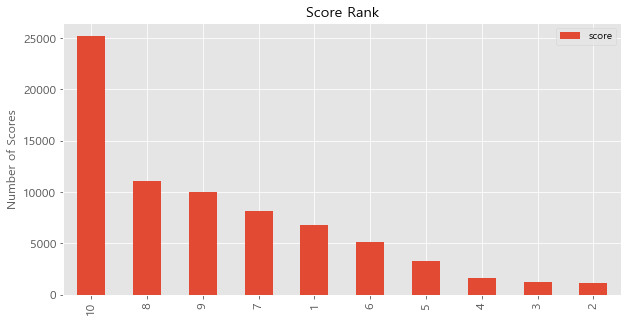

In [12]:
plt.style.use('ggplot')
df.score.value_counts().plot(kind = 'bar', title = 'Score Rank',
                            figsize = (10, 5), legend = True, fontsize = 12)
plt.ylabel("Number of Scores", fontsize = 12)
plt.show()

## 3. 유틸리티 행렬(Utility Matrix)

각 원소 ** $ a_{ij} $ ** 가 유저(i)가 영화(j)에 준 평점을 의미하는 유틸리티행렬(U)를 만든다.

In [8]:
# LabelEncoder를 이용하여 user와 title을 수치화 한다
def execute_labeling(column_name):
    Lec = LabelEncoder()
    df_copy = df.copy()
    df_label = pd.DataFrame(Lec.fit_transform(df_copy[column_name].values), columns = [column_name+'_label'])
    return df_label

df_user = execute_labeling('user')
df_title = execute_labeling('title')

print(len(df_user['user_label'].value_counts()))
print(len(df_title['title_label'].value_counts()))

df_copy = df.copy()    # copy df
df_copy = df_copy.drop(df_copy.columns[[0, 1]], axis = 1)    # delete 'user', 'title' columns
df_label = pd.concat([df_user, df_title, df_copy], axis = 1)    # 라벨링한 컬럼과 기존 데이터프레임 합치기

df_label.tail(5)

1837
1593


,user_label,title_label,genre,score
73455,1797,263,액션,10
73456,1797,854,판타지,10
73457,1797,1369,드라마,9
73458,1797,1222,애니메이션,10
73459,1797,1156,코미디,10


In [9]:
# 유저와 영화 제목이 column이고 각 원소가 평점인 DataFrame을 생성
movie_list = list(df['title'].unique())
movie_list = sorted(movie_list, key=str)
df_matrix = pd.DataFrame(columns = ['user'] + movie_list)

user_num = len(df_label.user_label.unique())
movie_num = len(df_label.title_label.unique())

df_matrix

,user,007 스카이폴,007 스펙터,007 카지노 로얄,007 퀀텀 오브 솔러스,10억,12 몽키즈,127 시간,13시간,13일의 금요일,...,황후花,회사원,후궁 : 제왕의 첩,희생부활자,히든 아이덴티티,히든 페이스,히든 피겨스,히말라야,히트,히트맨: 에이전트 47


In [10]:
%%time
user_score_list = []    # df_matrix에서 'user' 컬럼을 제외한 컬럼. 즉, title 컬럼
for num in range(0, user_num):
    
    user_score_list = [0 for i in range(movie_num)]    # 값을 0으로 초기화
    df_tmp = df_label[df_label['user_label'] == num]    # 각 유저별로 묶는다
    
    #print(df_tmp.head(2))
    for j in df_tmp.index:
        
            user_score_list[df_tmp.ix[j]['title_label']-1] = df_tmp.ix[j]['score'] # user가 평가한 영화가 있다면 score를 채워넣는다
                
    df_matrix.loc[num] = [num] + user_score_list    # 행채우기

c:\Python36\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # Remove the CWD from sys.path while we load stuff.


Wall time: 6min 57s


In [13]:
# pickle 저장
file = df_matrix
directory = open('utilitymatrix', 'wb')
pickle.dump(file, directory)
directory.close()

In [113]:
# pickle 이용하여 DATA LOAD
f = open('utilitymatrix', 'rb')
utilitymatrix = pickle.load(f)

In [114]:
utilitymatrix.tail(2)

,user,007 스카이폴,007 스펙터,007 카지노 로얄,007 퀀텀 오브 솔러스,10억,12 몽키즈,127 시간,13시간,13일의 금요일,...,황후花,회사원,후궁 : 제왕의 첩,희생부활자,히든 아이덴티티,히든 페이스,히든 피겨스,히말라야,히트,히트맨: 에이전트 47
1835,1835,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1836,1836,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4. DATA SPLIT

In [115]:
train, test = train_test_split(utilitymatrix, random_state=5)

print(train.shape, test.shape, utilitymatrix.shape)

(1377, 1594) (460, 1594) (1837, 1594)


## 5. 협업 필터링을 이용한 영화 추천 알고리즘
- 사용자 기반 협업 필터링을 이용하여 영화 추천 알고리즘을 구현한다.
    1. 코사인 유사도와 KNN을 이용하여 유저(i)가 영화(j)에 평점을 준 가장 비슷한 다른 유저(u)를 찾는다.
    2. 유저(i)가 아직 평가하지 않은 영화(j)의 평점을 예측한다. (유저(u)의 평점을 가중 평균하여 계산)

#### (1) 유사도 척도
- 코사인 유사도를 이용하여 유틸리티 행렬에서 각 사용자의 짝 유사도를 계산한다.

In [9]:
def cosine_similarity(data_name):    
    from sklearn.metrics.pairwise import cosine_distances
    similarity = 1 - cosine_distances(data_name)    # 0에 가까워 질수록 유사함
    return similarity


distant = cosine_similarity(train)    # data set으로 train set을 넣음
print(dis.shape)
distant

(1377, 1377)


array([[ 1.        ,  0.98919249,  0.997108  , ...,  0.99861211,
         0.98736337,  0.99609698],
       [ 0.98919249,  1.        ,  0.98906735, ...,  0.9903404 ,
         0.97979131,  0.98950796],
       [ 0.997108  ,  0.98906735,  1.        , ...,  0.9978121 ,
         0.98820815,  0.99617032],
       ..., 
       [ 0.99861211,  0.9903404 ,  0.9978121 , ...,  1.        ,
         0.98831282,  0.9972455 ],
       [ 0.98736337,  0.97979131,  0.98820815, ...,  0.98831282,
         1.        ,  0.98681717],
       [ 0.99609698,  0.98950796,  0.99617032, ...,  0.9972455 ,
         0.98681717,  1.        ]])

#### (2) 유저(i)와 가장 비슷한 유저(u) 5명을 찾는다.
- NearestNeighbors를 사용하여 가장 유사한 5명의 유저를 찾는다.

In [76]:
# 사용하려는 데이터와 이웃의 수를 받아 유저(i)와 유사한 K명의 유저(u)를 찾음
def find_near_neighbor(data_name, K, user_num=None):
    
    from sklearn.neighbors import NearestNeighbors

    KNN = NearestNeighbors(n_neighbors = K + 1, metric = 'cosine')    # 유사한 5명을 찾기 위해 +1을 해줌
    KNN.fit(data_name)
    similar_distance, similar_users = KNN.kneighbors(data_name)
    
    similar_users = similar_users[user_num][1:]
    similar_users = list(similar_users)
    return similar_users

# 유저(i)와 유사한 K명의 유저(u)들의 거리 함수
def find_near_distance(data_name, K, user_num=None):
    
    from sklearn.neighbors import NearestNeighbors

    KNN = NearestNeighbors(n_neighbors = K + 1, metric = 'cosine')    
    KNN.fit(data_name)
    similar_distance, similar_users = KNN.kneighbors(data_name)
    similar_distance = similar_distance[user_num][1:]
    
    return similar_distance

In [72]:
# 유저 번호 10과 유사한 5명의 유저들의 번호
similiar_users_10 = find_near_neighbor(train, 5, 10)
print(similiar_users_10)

[1110, 639, 1273, 331, 200]


In [79]:
# 유저 번호 10과 유사한 5명의 유저와의 거리
similiar_distance_10 = find_near_distance(train, 5, 10)
print(similiar_distance_10)

[ 0.00011077  0.00011105  0.00011614  0.00012129  0.00013438]


#### (3) 유저(i)가 평가하지 않은 영화(j)의 평가를 예측하여 이를 기반으로 유저(i)에게 영화를 추천한다. 
- 유저(i)와 유사한 5명의 유저들이 아이템에 대해 평가한 가중평균을 이용하여 유저(i)의 평점을 예측한다.
- 예측한 평점이 3점 이상인 영화들을 추천 리스트로 만들어 유저(i)에게 2개의 영화를 랜덤으로 추천한다.

In [440]:
# make_df()로 부터 새로운 data frame을 받아 narray 형식으로 변환
def convert_narray(data_name, similiar_users_list):
    
    # target 유저와 유사한 5명의 유저로 이루어진 새로운 data frame 형성
    def make_df(data_name, similiar_users_list):
    
        titles = list(data_name.columns)
        new_df = pd.DataFrame(columns = titles)
    
        for i in range(len(similiar_users_list)):
    
            def concat_row(i):
            
                neigh_df = data_name[data_name['user'] == similiar_users_list[i]]
        
                return neigh_df
        
            df = pd.concat([new_df, concat_row(i)])
            new_df = df
        
        return new_df
    
    new_df = make_df(data_name, similiar_users_list)
    narray = new_df.values
    narray = narray[:,1:]
    
    return narray


# target 유저의 평점 계산
def cal_rating(narray_data, similiar_distance):
    
    rating_list = []    # 가중평균값을 담는 리스트
        
    for col_num in range(narray_data.shape[1]):
        sum=0
        rating = 0
        for i in range(1, len(narray_data[:, col_num])):
            sum += float(narray_data[:, col_num][i]) * float(similiar_distance[i])
        rating = sum/similiar_distance.sum()
    
        if rating < 1:
            rating = 1    # 만약 가중평균값이 1보다 작으면 1점으로 함
        elif rating > 10:
            rating = 10    # 만약 가중평균값이 10보다 작으면 10점으로 함
        else:
            rating = int(rating)    # 평점은 정수형
    
        rating_list.append(rating)
    
    return rating_list


# target 유저의 평점을 리스트로 변환하는 함수
def target_user_rating_list(target_user, data_name):
    
    # target 유저의 평점을 narray로 변환
    target_user = data_name[data_name['user']==target_user]
    target_user = target_user.values
    target_user = target_user[:, 1:]
    
    #narray로 변환된 target 유저의 평점을 리스트로 변환
    target_user_rating_list = []
    for i in range(target_user.shape[1]):
        raw_rating = target_user[0][i]
        target_user_rating_list.append(raw_rating)
    
    return target_user_rating_list


# recommendation function
def recommendation(rating_list, target_user_rating_list, data_name):
    
    # 만약 target 유저의 평점이 0이면, 가중치평균을 넣고, 그렇지 않으면 0을 넣는다.
    # 즉, 0값이 target 유저가 평가 했던 아이템인데, 이 아이템 외의 값을 추천받기 위함
    final_list = []
    for i in range(len(rating_list)):
        if int(target_user_rating_list[i]) != 0 :
            final_list.append(0)
        else:
            final_list.append(int(rating_list[i]))

    movie_num = []
    for i in range(len(final_list)):
        if final_list[i] >= 3:
            movie_num.append(i)
            
    movie_list = list(data_name.columns)
    movie_list = movie_list[1:]
    
    recommendation_all_list = []
    for i in movie_num:
        recommendation_all_list.append(movie_list[i])
    
    # 만약 추천 리스트가 2개 이상이라면 2편의 추천 리스트에서 영화를 추천한다.
    # 그렇지 않으면 영화 리스트에서 영화를 추천한다.
    if len(recommendation_all_list) >= 2:
        recommendation_selection = random.sample(recommendation_all_list, 2)
    else:
        recommendation_selection = random.sample(movie_list, 2)
    
    print('고객님 이 영화는 어떠세요?')
    return print(recommendation_selection)

### 예시

In [441]:
convert_narray = convert_narray(train, similiar_users_10)
cal_rating = cal_rating(convert_narray, similiar_distance_10)
target_user_rating_list = target_user_rating_list(10, train)

In [442]:
recommendation(cal_rating, target_user_rating_list, train)

고객님 이 영화는 어떠세요?
['스파이더맨 3', '보이후드']
